# Генератор данных для задач классификации

В этом блокноте рассматривается задача о классификации набора векторов. Под каждым вектором мы понимаем строго фиксированную по порядку совокупность признаков, числового типа. Каждая такая совокупность характеризует состояние исследуемой системы в определенный момент времени измерений. Предполагаемая система может находиться в трех состояниях. Поэтому исследуемый набор векторов строго разделяется на три класса. В качестве примера такой системы рассмотрим процесс фиксации электро-энцефалограммы (ЭЭГ) мозга. При фиксации ЭЭГ эксперт отмечает характерные временные участки, на которых электрический сигнал ЭЭГ имеет определенную частоту колебаний, отражающих ритмическую активность внутренних процессов в мозге. (Такие ритмы еще принято называть осцилляторными структурами.) Эксперт в зависимости от исследуемой проблемы может по-разному объединять эти активности в разные классы, отмечая те или иные колебания на записи ЭЭГ. На каждой такой отмеченной записи может присутствовать от одной до нескольких осцилляторных структур и фоновых шумов.

Установлены четыре наиболее доминантные ритмические активности: дельта, тетта, альфа и бетта.
Мы будем рассматривать три класса состояний мозга на ЭЭГ по соответствующим ритмам:<br>
1) фоновая слабовыраженная активность: суммарынй набор ритмов дельта, тетта, альфа и бетта<br>
2) сильно выраженная бетта-активность (высокие частоты): бетта ритм<br>
3) сильно выраженная альфа-активность (средние частоты): альфа ритм<br>

Каждый отдельно взятый ритм может быть описан колебательным процессом (например семейством функций sin/cos) c центральной частотой и дополнительными суб-гармониками. Под каждый ритм принято отводить диапазон частот. Таблица диапазонов частот ЭЭГ хорошо известна (на четыре указанных ритма выделяется спектральный диапазон от 0 до 30 Гц). Мы рассматриваем одноканальную запись ЭЭГ, на которой эксперт размечает все три состояния (1,2,3) как три вышеописанных класса активностей.<br>

Одноканальный ЭЭГ-сигнал в виде временного ряда мы преобразуем в набор векторов на основе преобразования Фурье со скользящим временным окном. Значения самого сигнала для нас не представляют особой ценности, а вот мгновенное состояние спектра как результат Фурье преобразования в каждой временной точке сигнала - это и будет информация для комплектации набора векторов. Эксперт при разметке определил три класса, следовательно мы анализируем 3 разных набора дискретизованных спектров. Дискретизованный спектр мы соотносим с вектором при решении задачи классификации состояний классам 1, 2 и 3. Будем рассматривать спектр от 1 до 50 Гц с дискретизацией 1 Гц, поэтому вектор будет иметь 50 координат. Ниже приведен код, который эмулирует опыт с ЭЭГ и дает соответствующую разбивку векторов по классам 1, 2 и 3.

In [1]:
import numpy as np
import math
import random
import pandas as pd



# additional functions:---------------------------------------------
def rand_int_array(low,high,size):
    return np.array(np.random.randint(low=low,high=high,size=size,dtype=int));

def rand_flt_array (low,high,size):
    return (high - low) * np.random.sample(size) + low


# The main settings store class:------------------------------------
class SettingsStore:
    
    def __init__ (self,delta_t,q_sample,t_min,t_max):
        self.delta_t = delta_t;
        self.q_sample = q_sample;
        self.t_min = t_min;
        self.t_max = t_max;
        self.relation_tau_pointers = rand_int_array(low=self.t_min, high=self.t_max, size=self.q_sample);
        self.q_points = self.relation_tau_pointers.sum();
        self.tau_pointers = None;
    
   
    def init_tau_pointers(self):
        self.tau_pointers = np.array([],dtype=int);
        
        sum = 0;
        for relation_tau_pointer in self.relation_tau_pointers:
            sum += relation_tau_pointer;
            self.tau_pointers = np.append(self.tau_pointers,int(sum));
            
        assert(sum==self.q_points);
        print ("  --> Settings store post construct completed {}".format(self));
        return self;
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);

    
# The class of EEG frequencies set definition:----------------------
class EegFreqs:
    
    def __init__ (self,freq_size):
        self.__delta_freqs = rand_flt_array(low=1,high=5,size=freq_size);
        self.__theta_freqs = rand_flt_array(low=4,high=8,size=freq_size);
        self.__alpha_freqs = rand_flt_array(low=7,high=15,size=freq_size);
        self.__betta_freqs = rand_flt_array(low=14,high=31,size=freq_size);
       
    def delta(self):
        return np.random.choice(self.__delta_freqs);
    def theta(self):
        return np.random.choice(self.__theta_freqs);
    def alpha(self):
        return np.random.choice(self.__alpha_freqs);
    def betta(self):
        return np.random.choice(self.__betta_freqs);
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);

    
# The class of EEG sin wave generators:-----------------------------
class EegGenerators:
    
    def __init__(self,eeg_freqs,settings,phase_scale,noise_ratio):
        self.__eeg_freqs = eeg_freqs;
        self.__settings = settings;
        
        self.__generator_cnt = 0;
        self.__phase_scale = phase_scale;
        self.__phase = 0.0;
        self.__noise_ratio = noise_ratio;
        self.__delta = eeg_freqs.delta();
        self.__theta = eeg_freqs.theta();
        self.__alpha = eeg_freqs.alpha();
        self.__betta = eeg_freqs.betta();
            
    def generate_background(self,i):
        xtr = self.__delta_signal(i);
        xtr += self.__theta_signal(i);
        xtr += self.__alpha_signal(i);
        xtr += self.__betta_signal(i);
        xtr += self.__noise_signal()
        return xtr;
    
    def generate_alpha(self,i):
        return 4.0*self.__alpha_signal(i)+self.__noise_signal();
    
    def generate_betta(self,i):
        return 4.0*self.__betta_signal(i)+self.__noise_signal();
        
    def __delta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__delta,i);
    
    def __theta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__theta,i);
    
    def __alpha_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__alpha,i);
    
    def __betta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__betta,i);
            
    def __sin (self, freq, index):
        return math.sin(2*math.pi*self.__settings.delta_t*freq*index+self.__phase);
    
    def __noise_signal(self):
        return random.gauss(mu=0, sigma=self.__noise_ratio)
    
    def __reset_phase (self):
        self.__phase = random.random()*math.pi;
        self.__delta = self.__eeg_freqs.delta();
        self.__theta = self.__eeg_freqs.theta();
        self.__alpha = self.__eeg_freqs.alpha();
        self.__betta = self.__eeg_freqs.betta();
        return self;
    
    def __control_generating (self):
        if self.__generator_cnt>=self.__phase_scale:
            self.__generator_cnt=0;
            self.__reset_phase();
        self.__generator_cnt+=1;
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);
        

# The main EEG waves array producer:--------------------------------
class EegWaves:
    
    def __init__ (self, settings,eeg_generators):
        self.signal=np.zeros(shape=(settings.q_points));
        self.indicator_signal=np.ndarray(shape=(2,settings.q_points),dtype=int);
        self.target_signal=np.zeros(shape=(settings.q_points));
        self.__settings = settings;
        self.__eeg_generators = eeg_generators;

    def make_waves(self):
        print("     > Launched making waves...")
        
        Qps = self.__settings.q_points;
        gen = self.__eeg_generators.generate_background;
        for i in range(0,Qps):
            self.signal[i] = gen(i);
            self.indicator_signal[0][i] = 0;
            self.indicator_signal[1][i] = 0;
            self.target_signal[i] = 1;
        print("     > Generating background was completed");
        
        Qs = self.__settings.q_sample;
        tau = self.__settings.tau_pointers;
        for j in range(0,Qs-1,2):
            select = self.__signal_selector();
            for i in range(tau[j],tau[j+1]):
                self.signal[i]=self.__generate_wave(select,i);
                self.indicator_signal[select][i]+=1;
                self.target_signal[i]+=(select+1);
        
        print("     > Made waves: {}".format(self));
        return self;
                
    def __generate_wave(self,selector,i):
        if selector==1:
            return self.__eeg_generators.generate_alpha(i);
        else:
            return self.__eeg_generators.generate_betta(i);
                
    def __signal_selector(self):
        if random.random()>0.5:
            return 1;
        else :
            return 0;
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);
        


In [2]:
#--------------------------------------------------------------------------------------
# Launching:---------------------------------------------------------------------------
random.seed(19121988);
np.random.seed(19121988);

settings = SettingsStore(delta_t=0.01,q_sample=20,
                         t_min=500,t_max=1000).init_tau_pointers();

eeg_freqs = EegFreqs(freq_size=20);
print("  --> EEG frequencies: {}".format(eeg_freqs));

eeg_generators = EegGenerators(eeg_freqs=eeg_freqs,settings=settings,
                               phase_scale=2000,noise_ratio=0.65);
print("  --> EEG generators: {}".format(eeg_generators));

eeg_waves = EegWaves(settings=settings,
                     eeg_generators=eeg_generators).make_waves();

#--------------------------------------------------------------------------------------

  --> Settings store post construct completed <class '__main__.SettingsStore'>: {'delta_t': 0.01, 'q_sample': 20, 't_min': 500, 't_max': 1000, 'relation_tau_pointers': array([786, 698, 835, 888, 785, 899, 993, 536, 677, 680, 932, 604, 834,
       802, 634, 544, 788, 524, 512, 556]), 'q_points': 14507, 'tau_pointers': array([  786,  1484,  2319,  3207,  3992,  4891,  5884,  6420,  7097,
        7777,  8709,  9313, 10147, 10949, 11583, 12127, 12915, 13439,
       13951, 14507])}
  --> EEG frequencies: <class '__main__.EegFreqs'>: {'_EegFreqs__delta_freqs': array([1.10867409, 2.2535888 , 3.66385008, 4.20867232, 3.06085952,
       2.74655422, 1.32039413, 4.10804169, 3.72943113, 1.77803669,
       4.96652018, 1.99136434, 1.91081126, 1.34714831, 2.21060983,
       3.58644474, 4.80565602, 4.84808981, 4.71682191, 1.17542208]), '_EegFreqs__theta_freqs': array([4.78577765, 7.38570275, 5.60017338, 7.4087335 , 4.20072186,
       5.46083317, 6.99052212, 6.04749304, 5.16175209, 6.03141944,
       6.

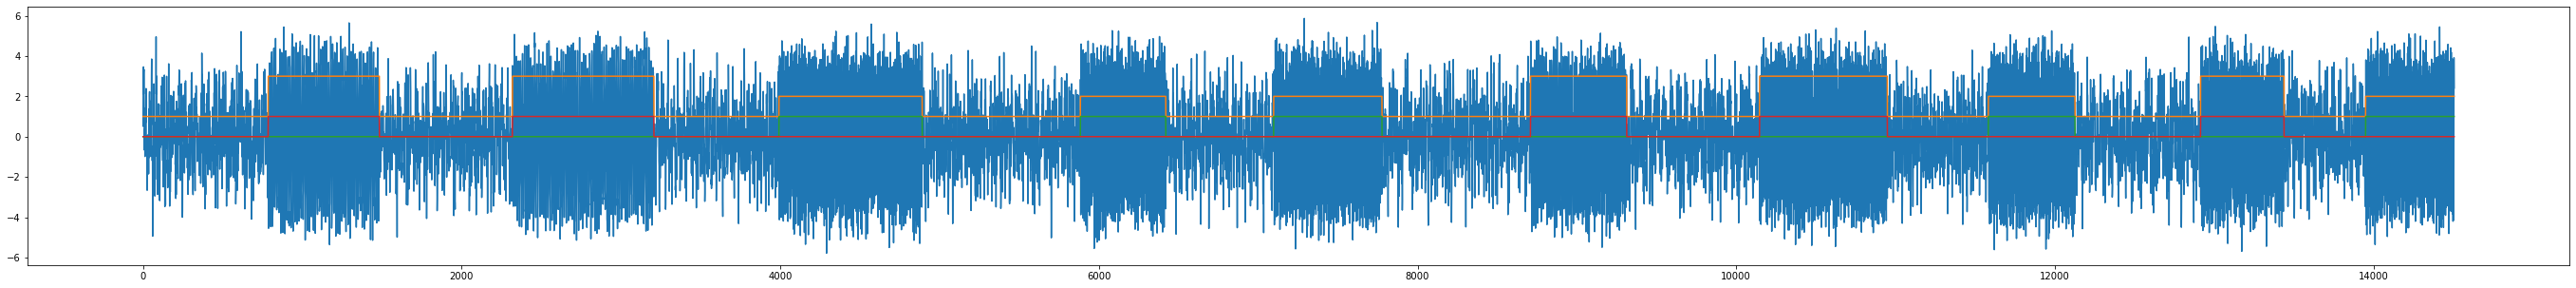

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 48,5

# Plotting signal:----------------------------------------------------
plt.plot(eeg_waves.signal);

# Plotting target signal:---------------------------------------------
plt.plot(eeg_waves.target_signal);

# Plotting EXPERT marker signal:--------------------------------------
plt.plot(eeg_waves.indicator_signal[0]);
plt.plot(eeg_waves.indicator_signal[1]);


  --> The Fourier image was calculated: shape=(14507,)


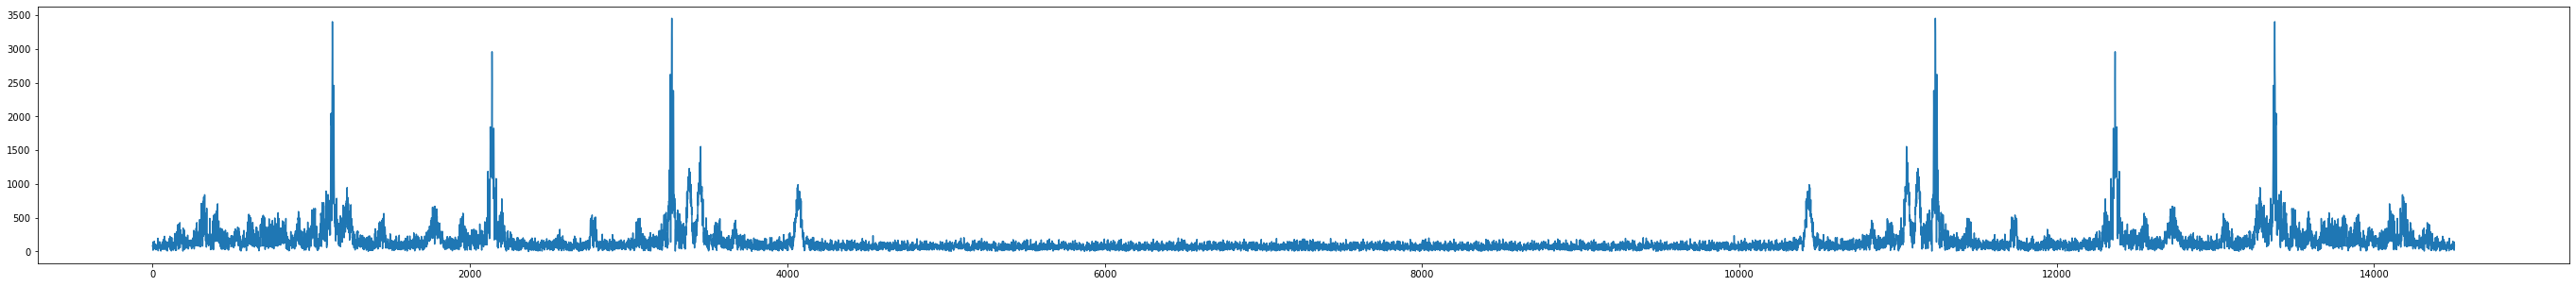

In [4]:

# Researching the EEG signal Fourier image:---------------------------

fourier_image = np.fft.fft(eeg_waves.signal);
fourier_image = np.absolute(fourier_image);
plt.plot(fourier_image);

print ("  --> The Fourier image was calculated: shape={}".format(fourier_image.shape))
# documents: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html


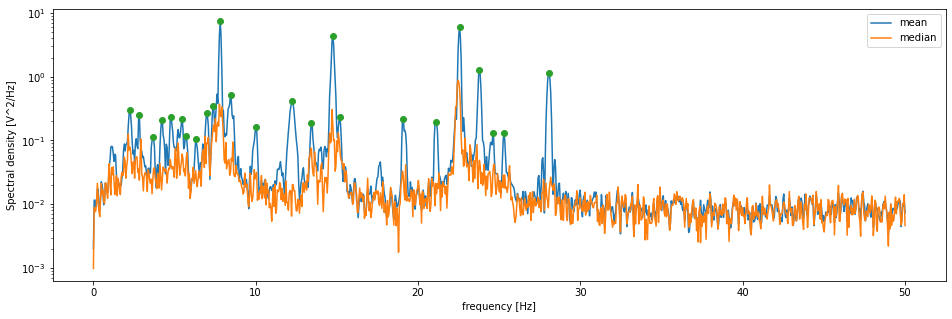

  --> The following peak frequencies were found: [ 2.24609375  2.83203125  3.66210938  4.19921875  4.78515625  5.46875
  5.71289062  6.29882812  6.98242188  7.37304688  7.8125      8.44726562
 10.00976562 12.25585938 13.42773438 14.74609375 15.18554688 19.09179688
 21.09375    22.55859375 23.77929688 24.609375   25.29296875 28.07617188]
  --> Next analysis have to consider 24 frequency characteristics


In [5]:
from scipy import signal as sp
rcParams['figure.figsize'] = 16,5

# Calculating and plotting the spectral density by Welch transform:-------------------------------
window_size_welch=2048
f, Pxx_den = sp.welch(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=window_size_welch)
f_med, Pxx_den_med = sp.welch(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=window_size_welch, average='median')
plt.semilogy(f, Pxx_den, label='mean')
plt.semilogy(f_med, Pxx_den_med, label='median')
plt.xlabel('frequency [Hz]')
plt.ylabel('Spectral density [V^2/Hz]')
plt.legend()


# Finding spectral density maxima:----------------------------------------------------------------
delta_f = 1.0/(settings.delta_t*window_size_welch);
peak_indexes,peak_params = sp.find_peaks(x=Pxx_den, width=2, height=0.1)
peak_frequencies = peak_indexes*delta_f
plt.plot(peak_frequencies, peak_params['peak_heights'], "o")
plt.show()

n_spectral_features = peak_frequencies.shape[0]
print ("  --> The following peak frequencies were found: {}".format(peak_frequencies))
print ("  --> Next analysis have to consider {} frequency characteristics".format(n_spectral_features))

# ------------------------------------------------------------------------------------------------
# documents: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html#scipy.signal.find_peaks_cwt

  --> Power spectral density (51, 14508)
  --> Frequency axis (51,)
  --> Time axis (14508,)
  --> Power spectral density matrix [[2.54218543e-02 2.02291475e-02 1.70422098e-02 ... 2.71126180e-03
  2.61023138e-03 2.27375008e-04]
 [9.04114922e-02 8.66704145e-02 8.45283886e-02 ... 3.06794731e-03
  3.04435349e-03 1.51219792e-03]
 [1.85527453e-01 1.93871491e-01 2.01933536e-01 ... 2.43295041e-03
  2.46180294e-03 2.48046398e-03]
 ...
 [1.36891523e-03 1.51207317e-03 1.67058444e-03 ... 8.95734947e-04
  8.78287018e-04 8.55673979e-04]
 [1.63849279e-03 1.78394495e-03 1.94083011e-03 ... 2.75099100e-03
  2.46385995e-03 2.19825591e-03]
 [2.96904729e-04 2.34048790e-04 1.74314139e-04 ... 3.77519121e-03
  3.30708380e-03 2.88267876e-03]]


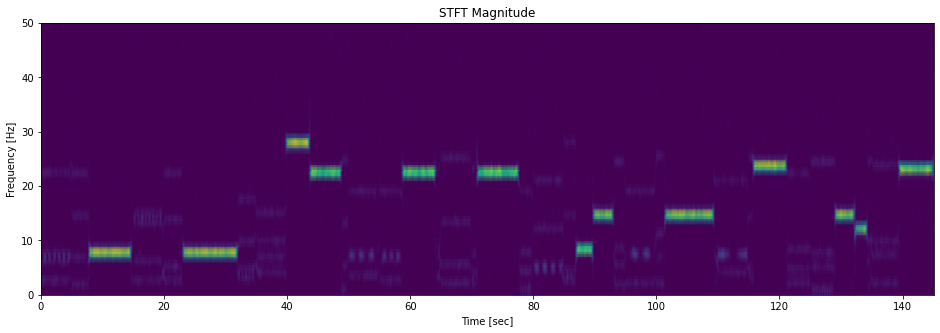

In [6]:

# Calculating the Fourier transform within the sliding window:----------------------------------
frequency_sampling = 1.0/settings.delta_t;
# Attention: 'settings.delta_t' and 'sliding_window_width' are selected according to the discritization
# frequency delta_f with in sliding window. The delta_f has to be equal to the 1 Hz.
delta_f = 1.0;
sliding_window_width = int(frequency_sampling/delta_f);


frequency_axis, time_axis, fourier_image_t = sp.stft(x=eeg_waves.signal,
                                                     fs=frequency_sampling,
                                                     nperseg=sliding_window_width,
                                                     detrend="constant",
                                                     noverlap=sliding_window_width-1)

power_spectral_density_t = np.abs(fourier_image_t)**2;
max_power_spectral_density = np.max(power_spectral_density_t);

print ("  --> Power spectral density {}".format(power_spectral_density_t.shape));
print ("  --> Frequency axis {}".format(frequency_axis.shape));
print ("  --> Time axis {}".format(time_axis.shape))
print ("  --> Power spectral density matrix {}".format(power_spectral_density_t));

plt.pcolormesh(time_axis, frequency_axis, power_spectral_density_t,
               vmin=0, vmax=max_power_spectral_density, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# documents: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html

In [7]:
#f, t, fourier_image_t_127 = sp.stft(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=128,detrend="constant",noverlap=127)
#power_spectral_density_t_127 = np.abs(fourier_image_t_127)**2;
#f, t, fourier_image_t_512 = sp.stft(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=512,detrend="constant",noverlap=511)
#power_spectral_density_t_512 = np.abs(fourier_image_t_512)**2;

#power_spectral_density_t = power_spectral_density_t_127*power_spectral_density_t_512


In [8]:
print ("  --> Temporal dependence of spectral density has the following shape={}".format(power_spectral_density_t.shape))

frequency_labels = [];

for i in range(0,frequency_axis.shape[0]):
    frequency_labels.append("f={}Hz".format(frequency_axis[i]));
    
print("  --> Made frequency_labels={}".format(frequency_labels));

  --> Temporal dependence of spectral density has the following shape=(51, 14508)
  --> Made frequency_labels=['f=0.0Hz', 'f=1.0Hz', 'f=2.0Hz', 'f=3.0Hz', 'f=4.0Hz', 'f=5.0Hz', 'f=6.0Hz', 'f=7.0Hz', 'f=8.0Hz', 'f=9.0Hz', 'f=10.0Hz', 'f=11.0Hz', 'f=12.0Hz', 'f=13.0Hz', 'f=14.0Hz', 'f=15.0Hz', 'f=16.0Hz', 'f=17.0Hz', 'f=18.0Hz', 'f=19.0Hz', 'f=20.0Hz', 'f=21.0Hz', 'f=22.0Hz', 'f=23.0Hz', 'f=24.0Hz', 'f=25.0Hz', 'f=26.0Hz', 'f=27.0Hz', 'f=28.0Hz', 'f=29.0Hz', 'f=30.0Hz', 'f=31.0Hz', 'f=32.0Hz', 'f=33.0Hz', 'f=34.0Hz', 'f=35.0Hz', 'f=36.0Hz', 'f=37.0Hz', 'f=38.0Hz', 'f=39.0Hz', 'f=40.0Hz', 'f=41.0Hz', 'f=42.0Hz', 'f=43.0Hz', 'f=44.0Hz', 'f=45.0Hz', 'f=46.0Hz', 'f=47.0Hz', 'f=48.0Hz', 'f=49.0Hz', 'f=50.0Hz']


In [9]:
# Making pandas data frame from transposed matrix of spectral dentsity
# and respective frequency labels:---------------------------------------------------

df = pd.DataFrame(data=power_spectral_density_t.T,columns=frequency_labels)

# Adding special column as the data frame target:------------------------------------
df["target"]=pd.Series(eeg_waves.target_signal)

# We do not consider ZERO frequecies. Let's remove this property:--------------------
df=df.drop(columns=["f=0.0Hz"])
df.info()
frequency_labels=frequency_labels[1:len(frequency_labels)]
print("  --> Made frequency_labels={}".format(frequency_labels));

# Nan controlling:-------------------------------------------------------------------
count_nan_in_df = df.isnull().sum().sum()
print ('  --> Original count of NaN: ' + str(count_nan_in_df))

# Deleting nan:----------------------------------------------------------------------
if count_nan_in_df>0:
    df = df.drop(df[df["target"].isnull()].index);
    count_nan_in_df = df.isnull().sum().sum()
    print ('  --> Residual count of NaN: ' + str(count_nan_in_df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 51 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   f=1.0Hz   14508 non-null  float64
 1   f=2.0Hz   14508 non-null  float64
 2   f=3.0Hz   14508 non-null  float64
 3   f=4.0Hz   14508 non-null  float64
 4   f=5.0Hz   14508 non-null  float64
 5   f=6.0Hz   14508 non-null  float64
 6   f=7.0Hz   14508 non-null  float64
 7   f=8.0Hz   14508 non-null  float64
 8   f=9.0Hz   14508 non-null  float64
 9   f=10.0Hz  14508 non-null  float64
 10  f=11.0Hz  14508 non-null  float64
 11  f=12.0Hz  14508 non-null  float64
 12  f=13.0Hz  14508 non-null  float64
 13  f=14.0Hz  14508 non-null  float64
 14  f=15.0Hz  14508 non-null  float64
 15  f=16.0Hz  14508 non-null  float64
 16  f=17.0Hz  14508 non-null  float64
 17  f=18.0Hz  14508 non-null  float64
 18  f=19.0Hz  14508 non-null  float64
 19  f=20.0Hz  14508 non-null  float64
 20  f=21.0Hz  14508 non-null  fl

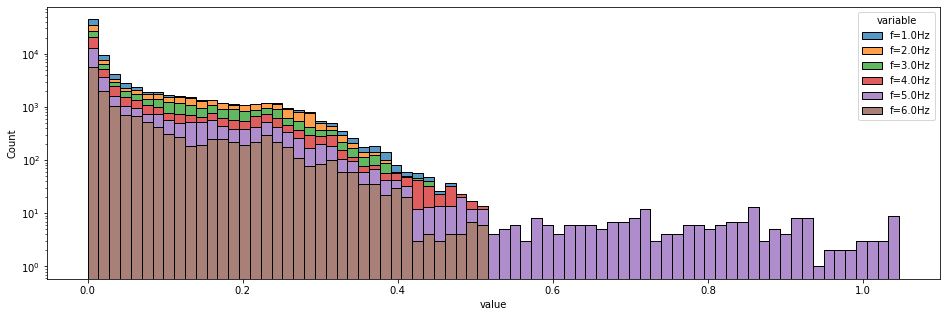

In [59]:
import seaborn as sb

sb.histplot(df[['f=1.0Hz', 'f=2.0Hz', 'f=3.0Hz', 'f=4.0Hz', 'f=5.0Hz', 'f=6.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);


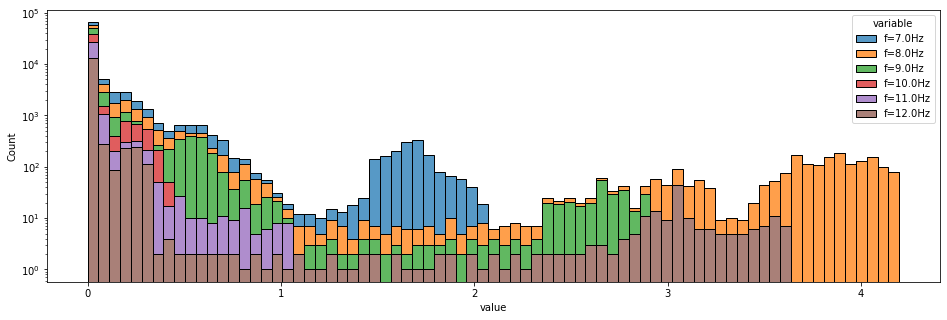

In [60]:
sb.histplot(df[['f=7.0Hz', 'f=8.0Hz', 'f=9.0Hz', 'f=10.0Hz', 'f=11.0Hz', 'f=12.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);

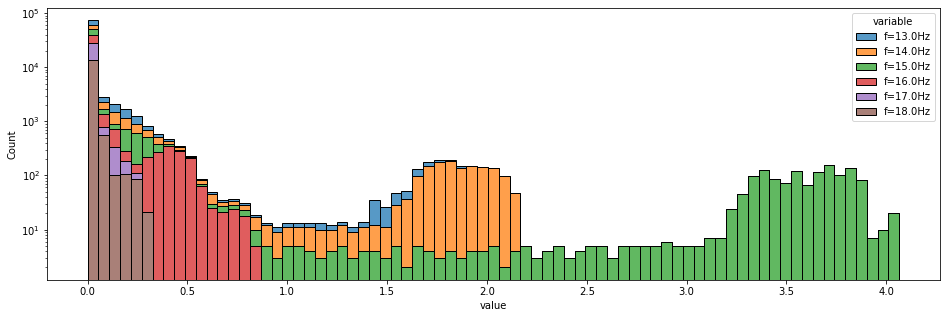

In [61]:
sb.histplot(df[['f=13.0Hz', 'f=14.0Hz', 'f=15.0Hz', 'f=16.0Hz', 'f=17.0Hz', 'f=18.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);

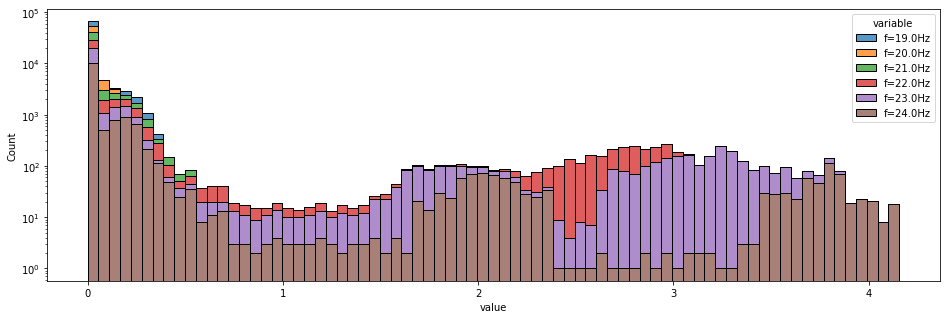

In [62]:
sb.histplot(df[['f=19.0Hz', 'f=20.0Hz', 'f=21.0Hz', 'f=22.0Hz', 'f=23.0Hz', 'f=24.0Hz']].melt(), x='value', hue='variable',
             multiple='stack', shrink=1., bins=75,log_scale=[False,True]);

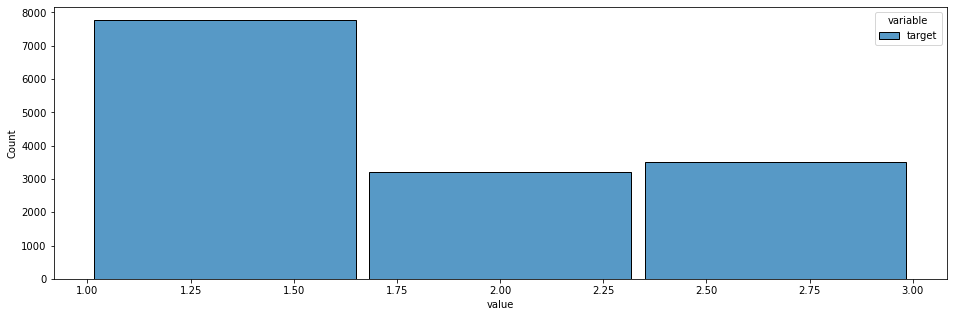

In [63]:
sb.histplot(df[['target']].melt(), x='value', hue='variable',
             multiple='stack', shrink=.95, bins=3,log_scale=False);

# Введение

На основе генератора мы получили data frame, состоящий из набора строк, каждая строка - это вектор. Координаты вектора это точки дискретизованного Фурье-спектра. По этим спектрам выделено 3 класса состояний при экспертной разметке. Набор векторов, уложенных в таблицу составляет данные в исследуемом data frame. Отдельной колонкой в data frame прописывается target. Эта колонка ставит в соответствие каждому вектору-строке его класс по экспертной разметке. Классов -три, поэтому и значения будут от 1 до 3 соответственно. Далее мы разобьем этот data frame на X и Y frame. В Х будут только вектора для классификации, как входные данные. По этим входным данным алгоритм классификации будет делать предположение о принадлежности объекта к определенному классу, выдавая его номер на выходе. В Y будут указания на правильные классы, по которым предполагается оценивать точность алгоритма классификации согласно экспертной разметке.

In [64]:
from sklearn.model_selection import train_test_split

# Создаем X ,Y для обучения и анализа:
X = pd.DataFrame(data=df,columns=frequency_labels);
Y = pd.DataFrame(data=df,columns=['target'])
X.info();
Y.info();

# Разделяем на тестовую и валидационную выборки:
# train---test----train-----test-----
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.25,shuffle=True)
print("X train shape={}".format(X_train.shape));
print("X test shape={}".format(X_test.shape));
print("Y train shape={}".format(Y_train.shape));
print("Y test shape={}".format(Y_test.shape));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14507 entries, 0 to 14506
Data columns (total 50 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   f=1.0Hz   14507 non-null  float64
 1   f=2.0Hz   14507 non-null  float64
 2   f=3.0Hz   14507 non-null  float64
 3   f=4.0Hz   14507 non-null  float64
 4   f=5.0Hz   14507 non-null  float64
 5   f=6.0Hz   14507 non-null  float64
 6   f=7.0Hz   14507 non-null  float64
 7   f=8.0Hz   14507 non-null  float64
 8   f=9.0Hz   14507 non-null  float64
 9   f=10.0Hz  14507 non-null  float64
 10  f=11.0Hz  14507 non-null  float64
 11  f=12.0Hz  14507 non-null  float64
 12  f=13.0Hz  14507 non-null  float64
 13  f=14.0Hz  14507 non-null  float64
 14  f=15.0Hz  14507 non-null  float64
 15  f=16.0Hz  14507 non-null  float64
 16  f=17.0Hz  14507 non-null  float64
 17  f=18.0Hz  14507 non-null  float64
 18  f=19.0Hz  14507 non-null  float64
 19  f=20.0Hz  14507 non-null  float64
 20  f=21.0Hz  14507 non-null  fl

In [65]:
# Lets observe the first 1000 vectors:
X.head(1000)

,f=1.0Hz,f=2.0Hz,f=3.0Hz,f=4.0Hz,f=5.0Hz,f=6.0Hz,f=7.0Hz,f=8.0Hz,f=9.0Hz,f=10.0Hz,...,f=41.0Hz,f=42.0Hz,f=43.0Hz,f=44.0Hz,f=45.0Hz,f=46.0Hz,f=47.0Hz,f=48.0Hz,f=49.0Hz,f=50.0Hz
0,0.090411,0.185527,0.101805,0.014818,0.072229,0.153807,0.162709,0.115802,0.047200,0.012686,...,0.001148,0.000434,0.002145,0.002027,0.001914,0.001484,0.000052,0.001369,0.001638,0.000297
1,0.086670,0.193871,0.106463,0.012552,0.075054,0.159774,0.168310,0.120677,0.048224,0.012211,...,0.001198,0.000405,0.002309,0.002038,0.001935,0.001628,0.000028,0.001512,0.001784,0.000234
2,0.084528,0.201934,0.111162,0.010349,0.077870,0.165319,0.173345,0.125317,0.049149,0.011662,...,0.001256,0.000380,0.002485,0.002040,0.001947,0.001784,0.000015,0.001671,0.001941,0.000174
3,0.083544,0.209681,0.115881,0.008261,0.080644,0.170416,0.177750,0.129686,0.049981,0.011043,...,0.001322,0.000360,0.002671,0.002032,0.001951,0.001955,0.000014,0.001845,0.002109,0.000120
4,0.075696,0.217124,0.120572,0.006343,0.083326,0.175077,0.181422,0.133783,0.050708,0.010372,...,0.001395,0.000348,0.002861,0.002020,0.001944,0.002141,0.000028,0.002041,0.002283,0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000032,0.003988,0.003482,0.008814,0.004084,0.012421,1.653495,3.863236,0.563478,0.003621,...,0.005793,0.005006,0.006165,0.017895,0.005869,0.035735,0.017442,0.002780,0.003769,0.002038
996,0.000722,0.004053,0.003828,0.008621,0.004402,0.012631,1.659490,3.865910,0.561159,0.004174,...,0.005624,0.005167,0.005938,0.017795,0.004642,0.035026,0.017649,0.002827,0.003776,0.002346
997,0.003631,0.004128,0.004177,0.008441,0.004744,0.012808,1.664812,3.868737,0.558593,0.004697,...,0.005452,0.005330,0.005675,0.017705,0.003542,0.034283,0.017825,0.002858,0.003768,0.002682
998,0.006834,0.004211,0.004499,0.008306,0.005068,0.012939,1.669556,3.871460,0.555950,0.005174,...,0.005286,0.005494,0.005387,0.017613,0.002586,0.033509,0.017965,0.002872,0.003749,0.003042


In [66]:
# Lets observe the first 1000 classifiers:
Y.head(1000)

,target
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
995,3.0
996,3.0
997,3.0
998,3.0


In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
    

# The basic method for lauching and calculating accuracy metrics:----------------
def execute_model (x_train,y_train,model,x_test,y_test):
    
    # FIT means learning:------------------------------------------ 
    model.fit(x_train,y_train)
    
    # Predict means analyzing test data:---------------------------
    y_predict = model.predict(x_test)
    
    # Accuracy metrics calculation:--------------------------------
    mse = mean_squared_error(y_test,y_predict)
    print("     > Mean squared error {}".format(mse))
    mae = mean_absolute_error(y_test,y_predict)
    print("     > Mean abs error {}".format(mae))
    
    # ATTENTION: Accuracy cannot be calculated for multiclass:
    try:
        accuracy = accuracy_score(y_test,y_predict)
        print ("     > Accuracy {}".format(accuracy))
    except:
        print("     > Accuracy was not calculated");
    try:
        confusion=confusion_matrix(y_test,y_predict)
        tp = confusion[1,1]
        tn = confusion[0,0]
        fp = confusion[0,1]
        fn = confusion[1,0]
        print ("     > TruePositive {} TrueNegative {} FalsePositive {} FalseNegative {}".format(tp,tn,fp,fn))
    except:
        print("     > Confusion was not calculated")
    
    r2s = r2_score(y_test,y_predict);
    print ("     > R2 = {}".format(r2s)); # 0 means bad , 1 means exceelent
    return y_predict;


# The basic function for executing scalers:--------------------------------------
def execute_scaling (x_train, scaler, x_test, make_data_frame):
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if make_data_frame:
        x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
        x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns);
    
    return (x_train_scaled, x_test_scaled)
    

# Линейная регрессия

Применим модель линейной регрессии для задачи классификации по 3 классам из X и Y соответственно

In [68]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression();
execute_model(X_train,Y_train,lin_reg,X_test,Y_test)


     > Mean squared error 0.0222246041712483
     > Mean abs error 0.093383083799091
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9679777350007126


array([[2.00142116],
       [2.94873675],
       [2.01945176],
       ...,
       [0.99706894],
       [1.96979625],
       [2.93922149]])

<b>Анализ коэффициентов линейной регрессии</b><br>
Рассмотрим коэффициенты полученной регрессии. Количественная оценка поможет определить необходимость масштабирования входных векторов.

In [69]:
lin_reg.intercept_ # free coefficient w0 from y=w0+w1x1+w2x2+..+wNxN

array([0.79556598])

In [70]:
lin_reg.coef_ # all coefficients from y=w0+w1x1+w2x2+..+wNxN except w0

array([[-0.09241717, -0.23708241, -0.00856216, -0.15381069, -0.05443284,
         0.14123234,  0.04301604,  0.50017026,  0.27834948, -0.04506032,
         0.01538891,  0.76637428, -0.17814046,  0.48980946,  0.25888906,
         0.8017597 ,  1.17996144,  0.08360559,  0.09198672,  0.16256394,
        -0.00750737,  0.20165638,  0.18847322,  0.19534673,  0.21008191,
         0.32719958,  0.6577107 ,  0.19218399, -0.1397915 , -1.38669786,
         2.68890649,  0.16885224, -0.26872176,  1.96597189, -0.22146187,
        -0.35095168, -1.64696325, -0.12070911, -1.11586018,  0.31140087,
         0.75531441,  2.16588689, -3.1818112 ,  2.15012652, -1.1289653 ,
         0.49485395, -0.94703304,  1.21360623,  1.17408401, -1.22178877]])

Все коэффициенты модели линейной регрессии соответствуют соответствующим параметрам анализиуруемой выборки. Поэтому столбчатая
диаграмма покажет их величину 

Text(0, 0.5, 'property')

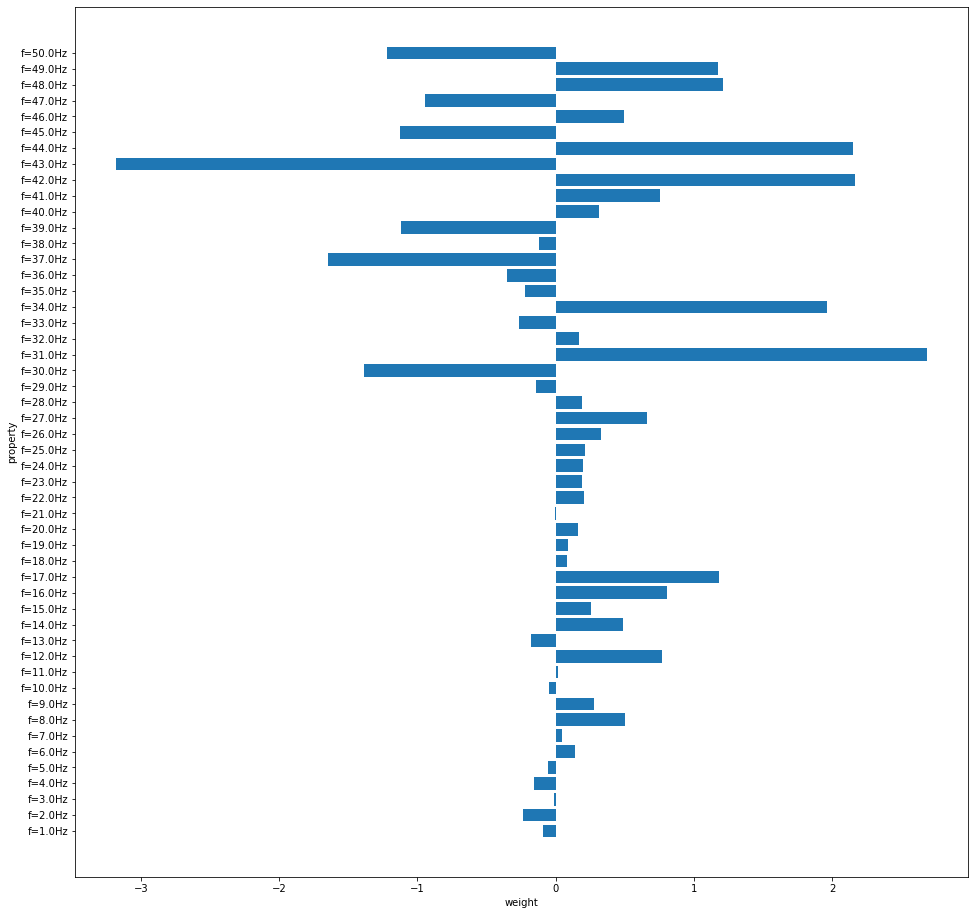

In [71]:

rcParams['figure.figsize'] = 16,16

plt.barh(X_train.columns,lin_reg.coef_.flatten())
plt.xlabel('weight')
plt.ylabel('property')

<b>Линейнай регрессия с масштабированием признаков</b>

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
#scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler();
scaler = MaxAbsScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,x_test=X_test,make_data_frame=True)

lin_reg = LinearRegression()
execute_model(X_train_scaler,Y_train,lin_reg,X_test_scaler,Y_test)


     > Mean squared error 0.022224604171248278
     > Mean abs error 0.09338308379909122
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9679777350007126


array([[2.00142116],
       [2.94873675],
       [2.01945176],
       ...,
       [0.99706894],
       [1.96979625],
       [2.93922149]])

Text(0, 0.5, 'property')

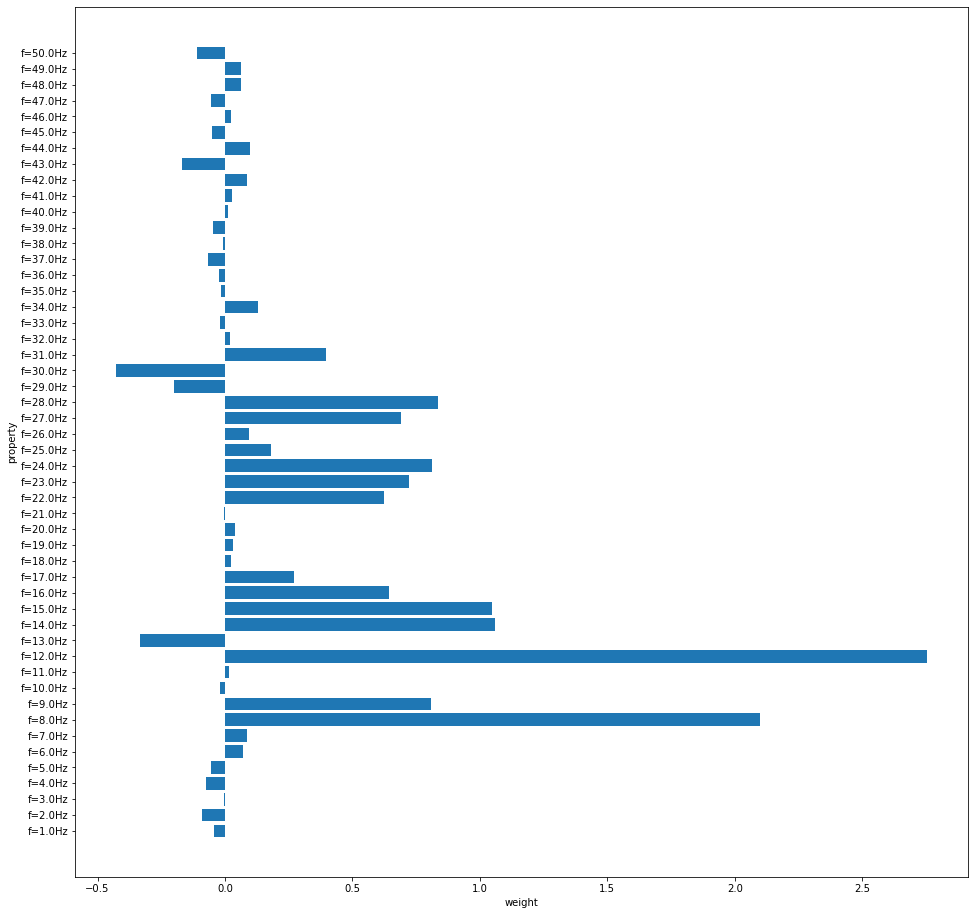

In [73]:
rcParams['figure.figsize'] = 16,16

plt.barh(X_train.columns,lin_reg.coef_.flatten())
plt.xlabel('weight')
plt.ylabel('property')

<b>Линейная регрессия с регуляризацией</b>

In [76]:
from sklearn.linear_model import Lasso

# Parameter ALPHA is responsible for regularisation
# The higher alpha - the stronger regularization and the lower overlearning
alpha_list = [0.01,0.001,0.0001,0.00001,0.000001];

for alpha in alpha_list:
    print ('  --> Lasso regularization {}'.format(alpha));
    execute_model(X_train,Y_train,Lasso(alpha=alpha),X_test,Y_test)


  --> Lasso regularization 0.01
     > Mean squared error 0.03462549597655624
     > Mean abs error 0.11270087685815774
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9501099412457717
  --> Lasso regularization 0.001
     > Mean squared error 0.024824617866320307
     > Mean abs error 0.09681797896383858
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9642315118102415
  --> Lasso regularization 0.0001
     > Mean squared error 0.022677438476253385
     > Mean abs error 0.0922203794391358
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9673252698317536
  --> Lasso regularization 1e-05
     > Mean squared error 0.02217465874493797
     > Mean abs error 0.09258678161836024
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9680496987425407
  --> Lasso regularization 1e-06
     > Mean squared error 0.022209893905044655
     > Mean abs error 0.093

In [79]:
from sklearn.linear_model import Ridge

alpha_list = [10.0,5.0,1.0,0.1,0.01,0.001,0.0001];

for alpha in alpha_list:
    print ('  --> Ridge regularization {}'.format(alpha));
    execute_model(X_train,Y_train,Ridge(alpha=alpha),X_test,Y_test)


  --> Ridge regularization 10.0
     > Mean squared error 0.02365062904174642
     > Mean abs error 0.0937456138990411
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9659230506541747
  --> Ridge regularization 5.0
     > Mean squared error 0.022988131559297523
     > Mean abs error 0.09283591893589052
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9668776084848056
  --> Ridge regularization 1.0
     > Mean squared error 0.022447472703984096
     > Mean abs error 0.09204938093117336
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.967656615436095
  --> Ridge regularization 0.1
     > Mean squared error 0.022197975026398867
     > Mean abs error 0.09218736567869691
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9680161035370655
  --> Ridge regularization 0.01
     > Mean squared error 0.02218271583510496
     > Mean abs error 0.093027263722

Масштабирование признаков не дало ощутимого прироста для решения этой задачи. Регуляризация подтвердила исходные цифры по точности, но дополнительных преимуществ не выявленно.

# Метод опорных векторов

Применим метод опорных векторов для задачи классификации по 3 классам из X и Y соответственно

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Support vector machine is sensible for non scaled data. That is why
# we have to use scaler
scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=True);

#X_train_scaler.describe()

In [81]:
from sklearn.svm import SVC

c_param_values = np.linspace(start=0.1,stop=2.1, num=20)
for c_param in c_param_values:
    print("  --> Executing SVC with c={}".format(c_param))
    execute_model(X_train_scaler,Y_train["target"],SVC(C=c_param),X_test_scaler,Y_test["target"])


  --> Executing SVC with c=0.1
     > Mean squared error 0.01488833746898263
     > Mean abs error 0.009190331770976933
     > Accuracy 0.993658671078026
     > TruePositive 2364 TrueNegative 5825 FalsePositive 1 FalseNegative 37
     > R2 = 0.9785481764193866
  --> Executing SVC with c=0.20526315789473684
     > Mean squared error 0.011763624666850473
     > Mean abs error 0.006984652145942468
     > Accuracy 0.9954048341145115
     > TruePositive 2378 TrueNegative 5824 FalsePositive 1 FalseNegative 23
     > R2 = 0.9830504109980339
  --> Executing SVC with c=0.31052631578947365
     > Mean squared error 0.01213123793768955
     > Mean abs error 0.007352265416781546
     > Accuracy 0.9950372208436724
     > TruePositive 2379 TrueNegative 5818 FalsePositive 6 FalseNegative 22
     > R2 = 0.9825207363417224
  --> Executing SVC with c=0.4157894736842105
     > Mean squared error 0.01084459148975278
     > Mean abs error 0.006617038875103391
     > Accuracy 0.9954967374322213
     > TrueP

# Алгоритм K- ближайших соседей (KNN)

Применим метод K- ближайших соседей для задачи классификации по 3 классам из X и Y соответственно

In [82]:

scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=True);
#X_train_scaler.describe()

In [83]:
from sklearn.neighbors import KNeighborsClassifier

for n_neighbours in range(1,n_spectral_features):
    print("  --> Executing KNN n_neighbours={}".format(n_neighbours))
    execute_model(X_train_scaler,Y_train["target"],
                  KNeighborsClassifier(n_neighbors=n_neighbours),X_test_scaler,Y_test["target"])


  --> Executing KNN n_neighbours=1
     > Mean squared error 0.011212204760591857
     > Mean abs error 0.00680084551052293
     > Accuracy 0.9954048341145115
     > TruePositive 2381 TrueNegative 5813 FalsePositive 6 FalseNegative 20
     > R2 = 0.983844922982501
  --> Executing KNN n_neighbours=2
     > Mean squared error 0.015072144104402168
     > Mean abs error 0.009006525135557393
     > Accuracy 0.994026284348865
     > TruePositive 2372 TrueNegative 5820 FalsePositive 3 FalseNegative 29
     > R2 = 0.978283339091231
  --> Executing KNN n_neighbours=3
     > Mean squared error 0.0149802407866924
     > Mean abs error 0.009098428453267164
     > Accuracy 0.9938424777134455
     > TruePositive 2375 TrueNegative 5807 FalsePositive 9 FalseNegative 26
     > R2 = 0.9784157577553088
  --> Executing KNN n_neighbours=4
     > Mean squared error 0.017277823729436634
     > Mean abs error 0.010476978218913703
     > Accuracy 0.9929234445363477
     > TruePositive 2369 TrueNegative 5814 Fa

Метод SVC (опорных векторов) по сравнению с KNN (ближайшими соседями) показал более лучший результат в абсолютных значениях метрики r2-score 

# Деревья в решении задачи классификации

In [85]:
from sklearn.tree import DecisionTreeClassifier

for depth in range(1,n_spectral_features,1):
    print("  --> Executing DecisionTree depth={}".format(depth));
    execute_model(X_train,Y_train,
              DecisionTreeClassifier(max_depth=depth),X_test,Y_test)


  --> Executing DecisionTree depth=1
     > Mean squared error 1.0040437459792297
     > Mean abs error 0.5167723554820329
     > Accuracy 0.7268633397665656
     > TruePositive 2104 TrueNegative 5805 FalsePositive 24 FalseNegative 297
     > R2 = -0.44667390505062143
  --> Executing DecisionTree depth=2
     > Mean squared error 0.4750482492417976
     > Mean abs error 0.2519069938424777
     > Accuracy 0.8596636338571823
     > TruePositive 2103 TrueNegative 4752 FalsePositive 15 FalseNegative 29
     > R2 = 0.3155279253815412
  --> Executing DecisionTree depth=3
     > Mean squared error 0.11267346751217719
     > Mean abs error 0.07094936127194192
     > Accuracy 0.9499126918481757
     > TruePositive 2104 TrueNegative 5743 FalsePositive 21 FalseNegative 28
     > R2 = 0.8376547178405436
  --> Executing DecisionTree depth=4
     > Mean squared error 0.046227368808013966
     > Mean abs error 0.025089605734767026
     > Accuracy 0.9854792758018565
     > TruePositive 2373 TrueNegati

<b>Ансамбли деревьев</b>

In [86]:
# Random forest . It's used an assembly of trees. The grouped trees are named as bagging.
# The quorum of groups are determined the class of the classified object
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = [{'n_estimators':[3,6,9],'max_features':np.arange(5,10),'max_depth':np.arange(5,15)}]

# n_estimators - is the number of trees 
# max_features - Max parameters per tree
# max_depth - max depth of the each tree
# grid search with cross validation. cv = 5. The first fourth groups (FOLDS) of the train set is used for FIT the last is used for vaidation
clf = GridSearchCV(estimator=RandomForestClassifier(random_state=100),param_grid=parameters,scoring='accuracy',cv=5)
clf.fit(X_train,Y_train["target"])

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid=[{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                          'max_features': array([5, 6, 7, 8, 9]),
                          'n_estimators': [3, 6, 9]}],
             scoring='accuracy')

In [87]:

means=clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean,std,params in zip(means,stds,clf.cv_results_['params']):
    print("%0.5f (%0.05f) =>%r"%(mean,std*2,params))
    
    

0.98511 (0.01007) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 3}
0.98952 (0.00667) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 6}
0.99117 (0.00965) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 9}
0.98208 (0.01349) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 3}
0.99173 (0.01195) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 6}
0.99311 (0.01031) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 9}
0.99035 (0.00718) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 3}
0.99504 (0.00511) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 6}
0.99393 (0.00847) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 9}
0.99255 (0.00481) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 3}
0.99669 (0.00413) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 6}
0.99559 (0.00684) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 9}
0.98593 (0.01475) =>{'max_depth': 5, 'max_features': 9, 'n_estimators': 3}
0.98897 (0.01003) =>{'max

In [88]:
# selected the best params from the grid search:r
random_forest_classifier = RandomForestClassifier(max_depth=9,max_features=5,n_estimators=9)
execute_model(X_train,Y_train["target"],random_forest_classifier,X_test,Y_test["target"])


     > Mean squared error 0.014796434151272861
     > Mean abs error 0.008914621817847624
     > Accuracy 0.994026284348865
     > TruePositive 2379 TrueNegative 5811 FalsePositive 11 FalseNegative 22
     > R2 = 0.9786805950834645


array([2., 3., 2., ..., 1., 2., 3.])

# Конвеерный алгоритм: АГК и деревья

In [89]:
# document source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import PCA


# Scaling:-------------------------------------------------------------
scaler = MinMaxScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=False);


# Applying PCA:-------------------------------------------------------
pca = PCA (n_components=int(n_spectral_features/2));

X_train_pca=pca.fit_transform(X_train_scaler);
X_test_pca = pca.transform(X_test_scaler)

print("PCA explained variance {}".format(pca.explained_variance_ratio_))
print("X test PCA shape = {}".format(X_test_pca.shape))


# Executing decision tree with PCA:----------------------------------
for depth in range(1,n_spectral_features,1):
    print("  --> Executing DecisionTree depth={}".format(depth));
    execute_model(X_train_pca,Y_train,
              DecisionTreeClassifier(max_depth=depth),X_test_pca,Y_test)


PCA explained variance [0.15645843 0.13619182 0.12501063 0.05288704 0.05147662 0.04605437
 0.04210651 0.0367391  0.02925681 0.02807695 0.02612585 0.02451032]
X test PCA shape = (10881, 12)
  --> Executing DecisionTree depth=1
     > Mean squared error 0.34197224519805164
     > Mean abs error 0.2813160555096039
     > Accuracy 0.74901203933462
     > TruePositive 0 TrueNegative 5529 FalsePositive 0 FalseNegative 190
     > R2 = 0.5072701509662827
  --> Executing DecisionTree depth=2
     > Mean squared error 0.12875654811138681
     > Mean abs error 0.06810035842293907
     > Accuracy 0.9622277364212848
     > TruePositive 2343 TrueNegative 5506 FalsePositive 23 FalseNegative 36
     > R2 = 0.814481451626918
  --> Executing DecisionTree depth=3
     > Mean squared error 0.04512452899549674
     > Mean abs error 0.025089605734767026
     > Accuracy 0.9849278558955978
     > TruePositive 2369 TrueNegative 5779 FalsePositive 23 FalseNegative 32
     > R2 = 0.9349824359377708
  --> Executi

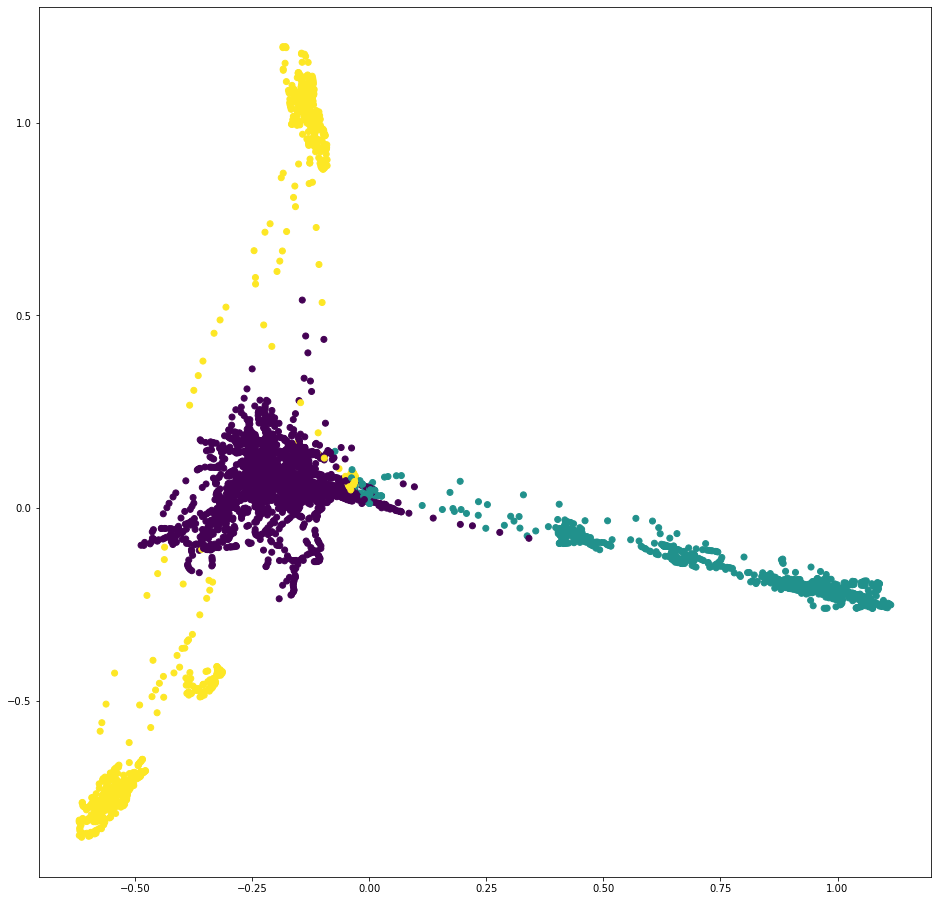

In [90]:
from sklearn.decomposition import PCA


# Reseaching PCA transform output:-----------------------------
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)

pca = PCA (n_components=33)
cluster = pca.fit_transform(X_train_scaler)
cluster2 = X_train_scaler @ pca.components_.T

i1 = 0;
i2 = 1;

x=cluster[0:cluster.shape[0],i1:i1+1];
y=cluster[0:cluster.shape[0],i2:i2+1];
x1=cluster2[0:cluster2.shape[0],i1:i1+1];
y1=cluster2[0:cluster2.shape[0],i2:i2+1];

#plt.scatter(x,y,c=Y_train["target"]);
plt.scatter(x1,y1,c=Y_train["target"]);



Дополнительный АГК к дереву решений планировался как алгоритм предварительного сжатия и сглаживания. В задачах классификации
зашумленных данных это совсем не лишняя процедура. Однако в данном случае этот подход проигрывает простому дереву решений. На рисунке выше показан кластер из разложений по первым двум компонентам. Это максимум информации о разделимости объектов в пространстве. Наиболее проблемные участки находятся на пересечении кластеров. Дерево решиений в представлении АГК работает хуже чем без него.

# Метод стохастического обобщения соседей (обзор)

In [149]:
from sklearn.manifold import TSNE

# document source: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# scaling:----------------------------------------------------------------
#scaler=StandardScaler()

#X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                   #            x_test=X_test,make_data_frame=True);



# learning rate influences on cluster density:---------------------------
#tsne = TSNE(n_components=2,
#            learning_rate=1000,
#            random_state=100,
#            #method='exact',
#            verbose=1
#           )
#X_train_tsne = tsne.fit_transform(X_train_scaler)

#plt.scatter(X_train_tsne[:,0],X_train_tsne[:,1],c=Y_train["target"])





In [150]:
#tsne2 = TSNE(n_components=2,
#            learning_rate=10,
#            random_state=100,
#            #method='exact',
#            verbose=1
#           )
#X_test_tsne = tsne2.fit_transform(X_test_scaler)

#plt.scatter(X_test_tsne[:,0],X_test_tsne[:,1],c=Y_test["target"])


In [151]:
#from sklearn.cluster import KMeans
#from sklearn.cluster import BisectingKMeans

#kMeans = KMeans(n_clusters=20)
#X_train_kmeans = MinMaxScaler().fit_transform(X_train_kmeans);
#X_train_kmeans = kMeans.fit_transform(X_train_kmeans)
#plt.scatter(X_train_kmeans[:,0],X_train_kmeans[:,1],c=Y_train["target"])

TSNE алгоритм довольно бесполезный для такого круга задач.<br>
1. Кластеры разделяются, но при этом геометрически они не различимы<br>
2. Плотность точек в кластерах не имеет хорошо выделенных максимумов<br>
3. В зависимости от данных и от количественных характеристик результат получается довольно сильно прыгающим<br>
4. Метод плохо сопрягается с каким-либо другим кластерным алгоритмом, чтобы устранить проблемы 1 - 3<br>

Общий вывод: Этот алгоритм хорош для представления данных нежели для анализа.

# Конвеерный алгоритм: Масштабирование + сжатие + кластеризация + классификация

Рассматривается комбинированный алгоритм, который опционально включает:<br>
1) масштабирование<br>
2) сжатие на основе АГК<br>
3) кластеризация пространства признаков на основе k-среднего<br>
4) построение классификации<br>
    
Количество кластеров и классов на стадии 3 и 4 мы ставим 3, потому что исходная задача имеет объекты трех классов.
Количество компонент сжатия мы устанавливаем на уровне чуть превышающеми количество гармоник в Фурье-спектре (см. выше).


In [152]:

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering.fit
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans.fit_transform
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans

enable_scaler=False

enable_pca=True
n_components_pca = 17

enable_bis_kmeans=False
enable_kmeans=False
n_clusters_kmeans = 3

n_neigbours_knn = 3
X_train_exp=X_train;
X_test_exp=X_test;

if enable_scaler:
    print("  --> Executing min/max scaler")
    scaler = MinMaxScaler()
    X_train_exp = scaler.fit_transform(X_train_exp)
    X_test_exp = scaler.transform(X_test_exp)

if enable_pca:
    print("  --> PCA: n_components={}".format(n_components_pca))
    pca = PCA (n_components=n_components_pca)
    X_train_exp = pca.fit_transform(X_train_exp)
    X_test_exp = pca.transform(X_test_exp)
    
if enable_bis_kmeans:
    print("  --> Bisecting K means: n_clusters={}".format(n_clusters_kmeans))
    kMeans = BisectingKMeans(n_clusters=n_clusters_kmeans)
    X_train_exp = kMeans.fit_transform(X_train_exp)
    X_test_exp = kMeans.transform(X_test_exp);
    
if enable_kmeans:
    print("  --> K means: n_clusters={}".format(n_clusters_kmeans))
    kMeans = KMeans(n_clusters=n_clusters_kmeans)
    X_train_exp = kMeans.fit_transform(X_train_exp)
    X_test_exp = kMeans.transform(X_test_exp);

print("  --> KNN n_neigbours={}".format(n_neigbours_knn))
knn = KNeighborsClassifier(n_neighbors=n_neigbours_knn);
execute_model(X_train_exp,Y_train["target"],knn,X_test_exp,Y_test["target"])



  --> PCA: n_components=17
  --> KNN n_neigbours=3
     > Mean squared error 0.008087491958459701
     > Mean abs error 0.004962779156327543
     > Accuracy 0.9965995772447386
     > TruePositive 2386 TrueNegative 5816 FalsePositive 5 FalseNegative 15
     > R2 = 0.9883471575611483


array([2., 3., 2., ..., 1., 2., 3.])